In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib import cm 
from matplotlib.colors import colorConverter, ListedColormap
import seaborn as sns  

# Set seaborn plotting style
sns.set_style('darkgrid')

# Set the seed for reproducibility
np.random.seed(seed=1)

#make data
from sklearn.datasets import make_classification

Logistic Regression is a shallow Neural Network. It only has one input layer and one output layer and no hidden layers. It is, however, a very good place to start to understand the inner workings of a Neural Network and fairly easy to implement from scratch.

First, let's create some artificial data for the binary classifier.

## Make data for classification

In [2]:
#make data
X,y = make_classification(n_samples=100, n_features=2, n_informative=2,n_redundant=0)
y = y.reshape(y.shape[0],1)
X.shape, y.shape

((100, 2), (100, 1))

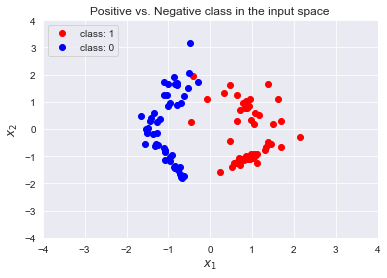

In [3]:
#visualize data
plt.figure(figsize=(6, 4))
plt.plot(X[np.where(y==1)[0],0], X[np.where(y==1)[0],1], 'ro', label='class: 1')
plt.plot(X[np.where(y==0)[0],0], X[np.where(y==0)[0],1], 'bo', label='class: 0')
plt.legend(loc=2)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-4, 4, -4, 4])
plt.title('Positive vs. Negative class in the input space')
plt.show()

## Forward propagation

We randomly initialize the weights for the output layer. The outer layer needs to have the same dimensions as *y*, in this case (100,1). Since there are no hidden layers, the outer layer is simply X * Weights. According the rules of matrix product, the wights matrix W needs to have dimensions (1,2) so that (100,2) x (2,1) = (100,1). For simplicty, however, we define W with shape (1,2) and take the transposed.

In [4]:
# Randomly inizialise the weights for the output layer
W = np.random.rand(1,X.shape[1]) 
W.shape

(1, 2)

The output of the classifier needs to be bounded between 0 and 1, therefore we also need an activation function to apply to the output layer. For a Logistic Regression, the activation function is simply the logistic (or sigmoid) function.

In [5]:
#define logistic function as our activation 
def sigmoid(z):
    return 1. / (1 + np.exp(-z))

In [7]:
output_layer = np.dot(X,W.T)
output_activation = sigmoid(output_layer)

The output activation is our prediction.

Let's visualize the decision boundary. The background color refers to the classification decision of the untrained classifier. Since the weights are still random and we haven't optimized them yet, we expect the classifier to be pretty bad at this point. In fact, it is not able to properly separate the positive class from the negative.

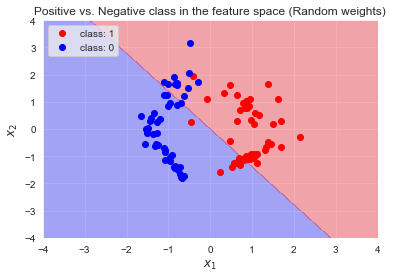

In [8]:
nb_of_xs = X.shape[0]
xsa = np.linspace(-4, 4, num=nb_of_xs)
xsb = np.linspace(-4, 4, num=nb_of_xs)

xx, yy = np.meshgrid(xsa, xsb)

prediction_matrix = np.zeros((nb_of_xs,nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        z = np.dot(np.asmatrix([xx[i,j], yy[i,j]]),W.T)
        prediction_matrix[i,j] = sigmoid(z)

cmap = ListedColormap([
        colorConverter.to_rgba('b', alpha=0.3),
        colorConverter.to_rgba('r', alpha=0.3)])

plt.figure(figsize=(6, 4))

plt.plot(X[np.where(y==1)[0],0], X[np.where(y==1)[0],1], 'ro', label='class: 1')
plt.plot(X[np.where(y==0)[0],0], X[np.where(y==0)[0],1], 'bo', label='class: 0')
plt.contourf(xx, yy, prediction_matrix, 1, cmap=cmap)
plt.legend(loc=2)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-4, 4, -4, 4])
plt.title('Positive vs. Negative class in the feature space (Random weights)')
plt.show()

## Back Propagation

This is where we optimize the weights with *Gradient Descent*. We iteratively calculate the loss between the prediction and the ground truth, compute the gradient and update the weights. As we get closer to the optimal values, we will observe the loss decrease and the steps of the gradient become smaller.

We first need to define a loss measure. In binary classification problems, it is common to use binary cross-entropy or log-loss so we will use that.

In [9]:
def cross_entropy(y_hat, y):
    return - np.mean(y * np.log(y_hat) + (1-y) * np.log(1-y_hat))

The *gradient* is the derivative of the loss function with respect to each of the weights (partial derivatives). It can be demonstrated that the derivative of cross-entropy function w.r.t. $W$ is $(y_{hat}-y)X$ where $y_{hat}=\sigma(z)$. We are not going to demonstrate it here but there's an excellent explanation at https://peterroelants.github.io/posts/cross-entropy-logistic/.

In [10]:
def gradient(y_hat,y,X):
    return np.dot((y_hat - y).T,X)

Finally, let's implement *Gradient Descent*. The Gradient Descent algorithm takes the gradient defined above and updates the parameters in the direction of the negative gradient (down along the loss function). Intuitively, the aim is to find that combination of parameters for which the derivative is zero, which means minimizing the loss function.

For Gradient Descent we need to define the *step* (or *learning rate*). It tunes the size of the step we take in the negative gradient direction. We also need to define a certain number of iterations for the algorithm to converge.

In [11]:
#define parameters for gradient descent
step = 0.05 
n_iter = 15 

losses = []
W_history = np.zeros((n_iter,W.shape[1]))

#iterate
for n in range(n_iter):
    output_layer = np.dot(X,W.T)
    output_activation = sigmoid(output_layer)
    loss = cross_entropy(output_activation, y)
    dW = gradient(output_activation,y,X)
    W -= step * dW
    losses.append(loss)
    W_history[n,:] = W[:]

Let's plot the loss. In our case, we reached the function minima with only 15 iterations. 

Text(0, 0.5, 'Loss')

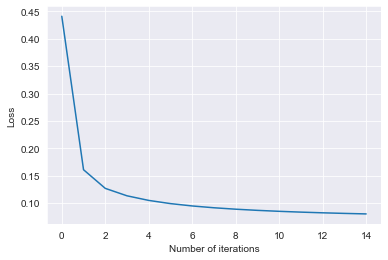

In [12]:
plt.plot(losses)
plt.xlabel('Number of iterations')
plt.ylabel('Loss')

We can also visualize what the gradient descent was doing at each iteration. From the figure, it's evident the model takes increasingly smaller steps as it approaches the minimum loss.

In [13]:
#calculate loss for all possible values in the parameter space
loss_matrix = np.zeros((W_history.shape[0],W_history.shape[0]))
for i in range(W_history.shape[0]):
    for j in range(W_history.shape[0]):
        W_tmp = np.array([W_history[i],W_history[j]]) 
        loss_matrix[i,j] = cross_entropy(sigmoid(np.dot(X,W_tmp.T)), y)

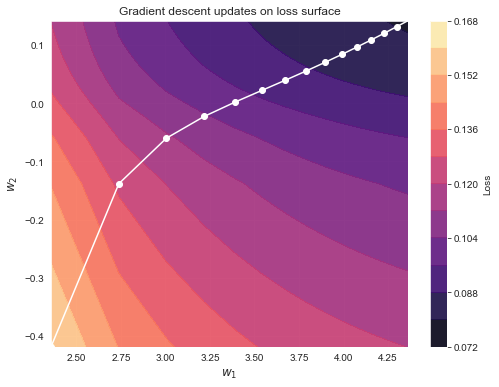

In [14]:
plt.figure(figsize=(8, 6))
plt.contourf(W_history[:,0], W_history[:,1], loss_matrix, 10, alpha=0.9, cmap=cm.magma)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Loss')

# Plot the updates
for i in range(1,W_history.shape[0]): 
    w1 = W_history[i-1,:]
    w2 = W_history[i,:]
    # Plot the weight-loss values that represents the update
    plt.plot(w1[0], w1[1], 'wo')  # Plot the weight-loss value
    plt.plot([w1[0], w2[0]], [w1[1], w2[1]], 'w-')

# Show figure
plt.xlabel('$w_1$', fontsize=12)
plt.ylabel('$w_2$', fontsize=12)
plt.title('Gradient descent updates on loss surface')
plt.show()

Let's look at the decision boundary again. Now the weights have been optimized and the classifier performs a lot better. There still are some mislassified points but overall the classifier does a good job in separating the two classes.

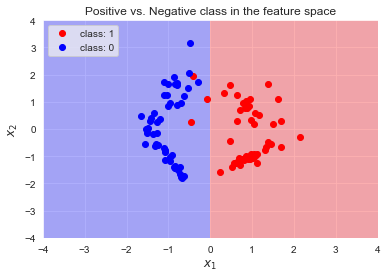

In [16]:
nb_of_xs = X.shape[0]
xsa = np.linspace(-4, 4, num=nb_of_xs)
xsb = np.linspace(-4, 4, num=nb_of_xs)

xx, yy = np.meshgrid(xsa, xsb)

prediction_matrix = np.zeros((nb_of_xs,nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        prediction_matrix[i,j] = sigmoid(np.asmatrix([xx[i,j], yy[i,j]])).item(0)

cmap = ListedColormap([
        colorConverter.to_rgba('b', alpha=0.3),
        colorConverter.to_rgba('r', alpha=0.3)])

plt.figure(figsize=(6, 4))
plt.plot(X[np.where(y==1)[0],0], X[np.where(y==1)[0],1], 'ro', label='class: 1')
plt.plot(X[np.where(y==0)[0],0], X[np.where(y==0)[0],1], 'bo', label='class: 0')
plt.contourf(xx, yy, prediction_matrix, 1, cmap=cmap)
plt.legend(loc=2)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-4, 4, -4, 4])
plt.title('Positive vs. Negative class in the feature space')
plt.show()


Inspiration for the pictures from https://peterroelants.github.io/posts/neural-network-implementation-part02/